In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow import keras

# Przygotowanie danych:

Wczytanie z pliku csv:

In [2]:
df = read_csv('data/data_single_loc.csv')
df

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,262.714033,259.900872,103298.015394,0.000000,0.0,1950-01-01 00:00:00,2.489513,3.817744
1,260.695745,258.184905,103401.866726,0.000000,0.0,1950-01-01 01:00:00,1.837656,3.726080
2,260.195929,257.699157,103434.928307,0.000000,0.0,1950-01-01 02:00:00,2.599009,3.537574
3,259.350219,256.948053,103418.318422,0.000000,0.0,1950-01-01 03:00:00,2.534284,3.147813
4,258.763065,256.665744,103419.030274,0.000000,0.0,1950-01-01 04:00:00,2.623488,3.713367
...,...,...,...,...,...,...,...,...
622387,274.643734,274.172750,100974.912154,0.000006,0.0,2020-12-31 19:00:00,0.809895,1.810642
622388,274.719036,274.144356,100973.148236,0.000005,0.0,2020-12-31 20:00:00,0.868971,1.490224
622389,274.310849,273.971416,100980.668096,0.000003,0.0,2020-12-31 21:00:00,0.774225,1.328229
622390,273.450250,273.092257,100972.962561,0.000002,0.0,2020-12-31 22:00:00,0.649268,0.561700


## Wybór zestawu uczacego i testowego:

In [3]:
train = df[df['Date Time']>='2001-01-01']
train = train[train['Date Time']<'2002-01-01']

test = df[df['Date Time']>='2002-01-01']
test = test[test['Date Time']<'2003-01-01']

## Zamiana daty na sygnał

In [4]:
def datetimeToSignal(df):
    date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

    def datetime_to_seconds(dates):
        return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

    timestamp_s = date_time.map(datetime_to_seconds)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

In [6]:
train.pop('Date Time')
test.pop('Date Time')

455832    2002-01-01 00:00:00
455833    2002-01-01 01:00:00
455834    2002-01-01 02:00:00
455835    2002-01-01 03:00:00
455836    2002-01-01 04:00:00
                 ...         
464587    2002-12-31 19:00:00
464588    2002-12-31 20:00:00
464589    2002-12-31 21:00:00
464590    2002-12-31 22:00:00
464591    2002-12-31 23:00:00
Name: Date Time, Length: 8760, dtype: object

In [8]:
train

,t2m,d2m,msl,tp,ssrd,windspeed_10,windspeed_100
447072,270.224287,269.086217,101808.956642,0.000043,0.0,4.142129,6.839433
447073,269.423607,268.177138,101837.316780,0.000048,0.0,3.983990,6.955347
447074,269.129495,267.806842,101871.661168,0.000030,0.0,3.527398,6.572829
447075,267.703544,266.325030,101896.985817,0.000016,0.0,3.175548,6.257602
447076,267.336093,265.745382,101916.412946,0.000005,0.0,3.013670,6.135714
...,...,...,...,...,...,...,...
455827,268.716680,266.967547,102182.755406,0.000364,0.0,4.235441,7.019842
455828,268.546564,266.426877,102303.220947,0.000238,0.0,4.918338,7.976831
455829,268.176845,266.142083,102400.963686,0.000204,0.0,5.307397,8.410755
455830,267.034420,264.758975,102492.461991,0.000164,0.0,5.672091,9.402890


## Normalizacja

In [9]:
values_train = train.values
values_test = test.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values_train)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(values_train[:,5].reshape(len(values_train),1))

values_train = scaler.transform(values_train)
values_test = scaler.transform(values_test)

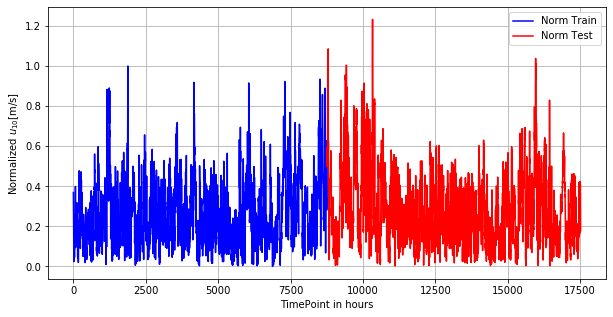

In [10]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('Normalized $u_{10}$[m/s]')
plt.grid()
plt.plot(range(len(values_train)),values_train[:,5],'b')
plt.plot(range(len(values_train),len(values_train)+len(values_test)),values_test[:,5],'r')
plt.legend(['Norm Train','Norm Test']);

## Zmiana szeregu czasowego na input/output

In [11]:
# Multiple steps predicted:

# # convert history into inputs and outputs
# def to_supervised(data, n_input, n_out=1):
#     X, y = list(), list()
#     in_start = 0
#     # step over the entire history one time step at a time
#     for _ in range(len(data)):
#         # define the end of the input sequence
#         in_end = in_start + n_input
#         out_end = in_end + n_out
#         # ensure we have enough data for this instance
#         if out_end < len(data):
#             X.append(data[in_start:in_end, :])
#             y.append(data[in_end:out_end, 0])
#         # move along one time step
#         in_start += 1
#     return array(X), array(y)

# One step predicted:
def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_end-1, 5]) # 5 indicates 'windspeed10' parameter
        # move along one time step
        in_start += 1
    return array(X), array(y).reshape((len(y),1))

X_train, y_train = to_supervised(values_train, n_input=24, n_out=6)
X_test, y_test = to_supervised(values_test, n_input=24, n_out=6)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8730, 24, 7)
(8730, 1)
(8730, 24, 7)
(8730, 1)


# Stworzenie i trening modeli

In [13]:
def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

def evaluate(model, X_test, y_test, display = True):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(mean_squared_error(testYTrue, testPredictions))
    
    if display:
        print('Test Score: %.4f RMSE' % (testScore))
        length = 168
        start = random.randrange(len(testYTrue)-length)
        end = start+length
        plt.figure(figsize=[10,5])
        plt.xlabel('TimePoint in hours')
        plt.ylabel('$windspeed_{10}[m/s]$')
        plt.grid()
        plt.plot(range(length), testYTrue[start:end],'k.')
        plt.plot(range(length),testPredictions[start:end],'r')
        plt.legend(['Actual','Predicted'])

    return testScore

def cross_corr(model, X_test, y_test):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)
    testPredictions = testPredictions.reshape((testPredictions.shape[0]))
    testYTrue = testYTrue.reshape((testYTrue.shape[0]))

    plt.figure(figsize=[10,5])
    plt.xcorr(testYTrue, testPredictions, usevlines=False)
    plt.grid()
    plt.title("Cross correlation between predictions and actual values")


## Dense:

In [12]:
dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,11)),
    Dense(units=24, activation='relu'),
    Dense(units=24, activation='relu'),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])
dense.summary()
compile_and_fit(dense, X_train, y_train)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24, 24)            288       
_________________________________________________________________
dense_1 (Dense)              (None, 24, 24)            600       
_________________________________________________________________
dense_2 (Dense)              (None, 24, 24)            600       
_________________________________________________________________
dense_3 (Dense)              (None, 24, 1)             25        
_________________________________________________________________
reshape (Reshape)            (None, 1, 24)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1)              25        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1)                 0

Test Score: 1.0531 RMSE


1.0531464042145686

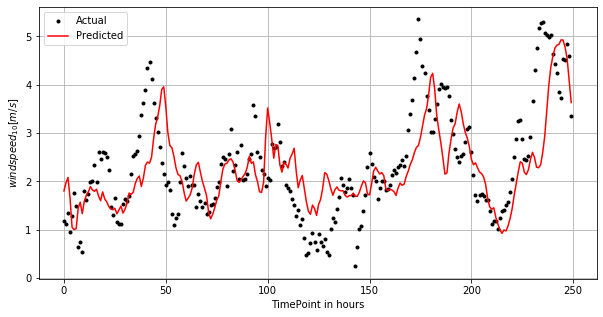

In [13]:
evaluate(dense, X_test, y_test)

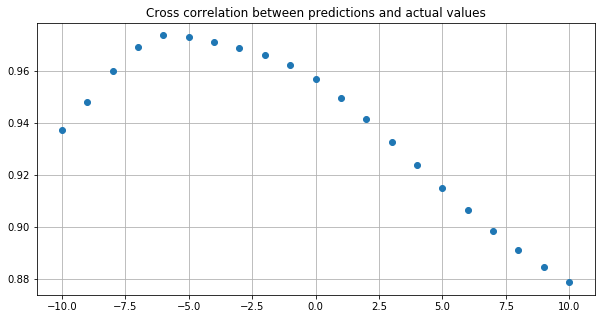

In [14]:
cross_corr(dense, X_test, y_test)

## LSTM

In [14]:
lstm = Sequential([
    LSTM(24, activation='relu', input_shape=(24,7), return_sequences=True),
    LSTM(24, activation='relu', return_sequences=True),
    LSTM(24, activation='relu'),
    Dense(1)
])
lstm.summary()
compile_and_fit(lstm, X_train, y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 24)            3072      
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 24)            4704      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 12,505
Trainable params: 12,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
273/273 [==============================] - 101s 353ms/step - loss: 0.0173
Epoch 2/20
273/273 [==============================] - 90s 331ms/step - loss: 0.0132
Epoch 3/20
273/273 [==============================] - 83s 304ms/step - loss: 0.01

In [23]:
lstm.save('workdir/saved_models/wind_lstm_no_time_var.h5')

Test Score: 1.0732 RMSE


1.073181832663957

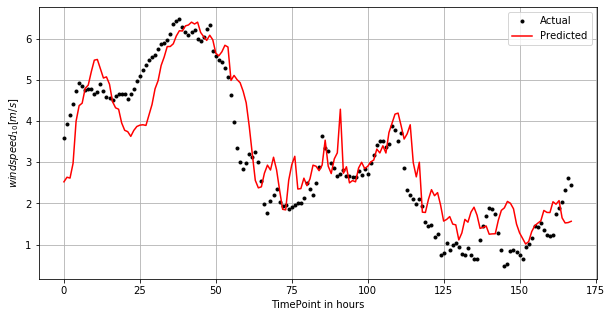

In [15]:
evaluate(lstm, X_test, y_test)

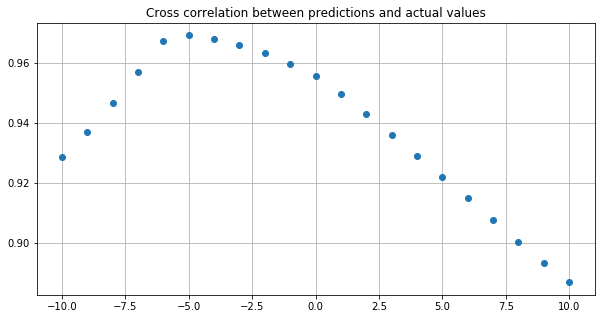

In [16]:
cross_corr(lstm, X_test, y_test)

In [19]:
lstm_with_dense = Sequential([
    LSTM(168, activation='relu', input_shape=(24,7), return_sequences=True),
    Dense(168, activation='relu'),
    Dense(24, activation='relu'),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])
lstm_with_dense.summary()
compile_and_fit(lstm_with_dense, X_train, y_train)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 168)           118272    
_________________________________________________________________
dense_4 (Dense)              (None, 24, 168)           28392     
_________________________________________________________________
dense_5 (Dense)              (None, 24, 24)            4056      
_________________________________________________________________
dense_6 (Dense)              (None, 24, 1)             25        
_________________________________________________________________
reshape (Reshape)            (None, 1, 24)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1, 1)              25        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1)                

Test Score: 1.2965 RMSE


1.296501213126103

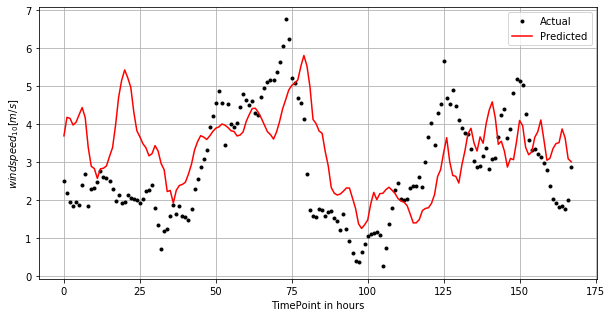

In [21]:
evaluate(lstm_with_dense, X_test, y_test)

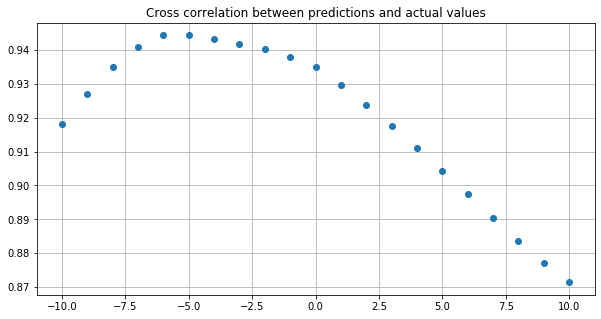

In [22]:
cross_corr(lstm_with_dense, X_test, y_test)

# Porównanie wyników

In [18]:
years = range(2002,2020)
years = [str(x) for x in years]

Xs = []
ys = []
look_back = 24
forward = 6

for year in years:
    test = df[df['Date Time']>=(year+'-01-01')]
    test = test[test['Date Time']<(str(int(year)+1)+'-01-01')]
    test = datetimeToSignal(test)
    test = test.values
    test = scaler.transform(test)
    X, y = to_supervised(test, look_back, forward)
    Xs.append(X)
    ys.append(y)

In [19]:
class mean_baseline():
    def predict(X):
        X = X[:,:,5].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(np.mean(item))
        Y = np.array(Y).reshape(len(Y),1)
        return Y

class last_baseline():
    def predict(X):
        X = X[:,:,5].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(item[-1])
        Y = np.array(Y).reshape(len(Y),1)
        return Y

mean = mean_baseline
last = last_baseline

Text(0.5, 0, 'RMSE for years 2002-2020')

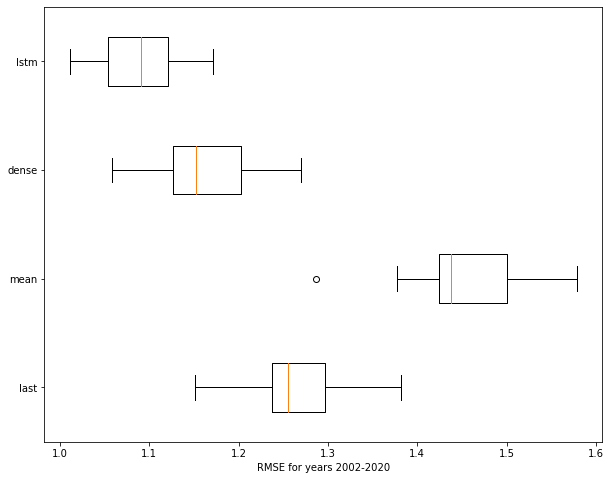

In [20]:
models = {
    "last": last,
    "mean": mean,
    "dense":dense, 
    "lstm":lstm
}

scores = {}
for key, model in models.items():
    rmses = []
    for i in range(len(years)):
        rmse = evaluate(model, Xs[i], ys[i], display=False)
        rmses.append(rmse)
    scores[key] = rmses

plt.figure(figsize=(10,8))
plt.boxplot(scores.values(), vert=False, labels=scores.keys())
plt.xlabel("RMSE for years 2002-2020")

# Concept drift

Text(0, 0.5, 'RMSE')

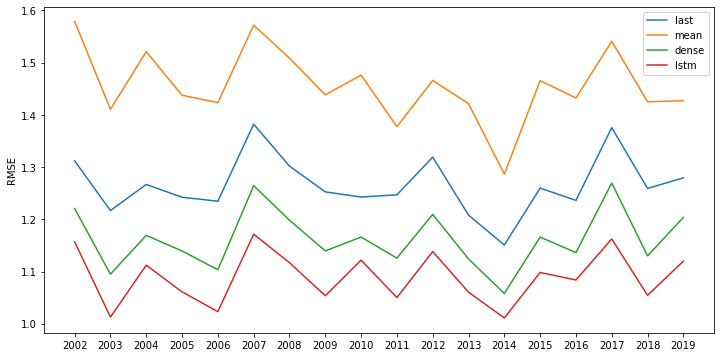

In [21]:
plt.figure(figsize=(12,6))
for key in scores.keys():
    plt.plot(years, scores[key])
plt.legend(scores.keys())
plt.ylabel("RMSE")

## CNN model

In [76]:
CONV_WIDTH = 24
cnn = Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :], input_shape = (24,11)),
    # Shape => [batch, 1, conv_units]
    keras.layers.Conv1D(24, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    Dense(1, kernel_initializer=keras.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    Reshape([1])
])

# lstm = Sequential([
#     LSTM(24, activation='relu', input_shape=(24,11), return_sequences=True),
#     LSTM(24, activation='relu', return_sequences=True),
#     LSTM(24, activation='relu'),
#     Dense(1)
# ])
# cnn.build()
cnn.summary()
compile_and_fit(cnn, X_train, y_train)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_10 (Lambda)           (None, 24, 11)            0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 1, 24)             6360      
_________________________________________________________________
dense_19 (Dense)             (None, 1, 1)              25        
_________________________________________________________________
reshape_7 (Reshape)          (None, 1)                 0         
Total params: 6,385
Trainable params: 6,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
273/273 [==============================] - 2s 4ms/step - loss: 0.0176
Epoch 2/20
273/273 [==============================] - 1s 4ms/step - loss: 0.0115
Epoch 3/20
273/273 [==============================] - 1s 4ms/step - loss: 0.0103
Epoch 

Test Score: 1.0722 RMSE


1.0721789575056806

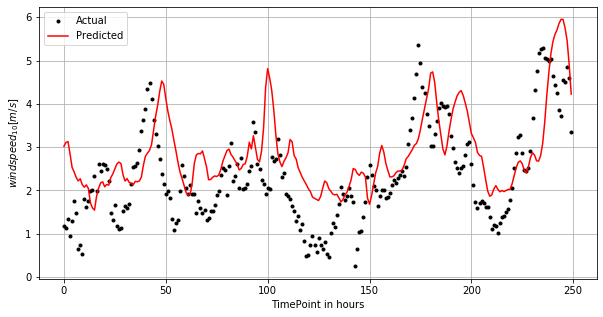

In [77]:
evaluate(cnn, X_test, y_test)

## Wavenet

In [82]:
wavenet = Sequential()
wavenet.add(keras.layers.InputLayer(input_shape=[24, 11]))
for rate in (1, 2, 4, 8) * 2:
    wavenet.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
wavenet.add(keras.layers.Conv1D(filters=24, kernel_size=1))
wavenet.add(Dense(1))
wavenet.add(Reshape([1,24]))
wavenet.add(Dense(1))
wavenet.add(Reshape([1]))

wavenet.summary()
compile_and_fit(wavenet, X_train, y_train)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_68 (Conv1D)           (None, 24, 20)            460       
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 24, 20)            820       
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 24, 20)            820       
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 24, 20)            820       
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 24, 20)            820       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 24, 20)            820       
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 24, 20)          

Test Score: 0.9246 RMSE


0.9246402115996669

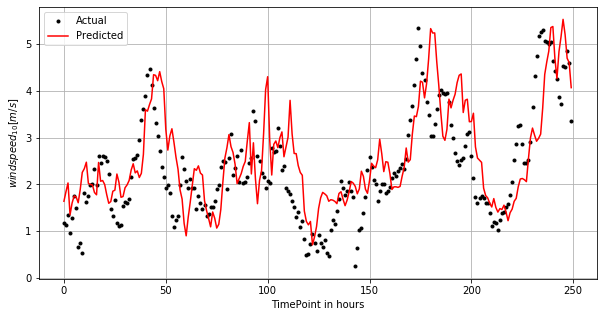

In [83]:
evaluate(wavenet, X_test, y_test)

Text(0.5, 0, 'RMSE for years 2002-2020')

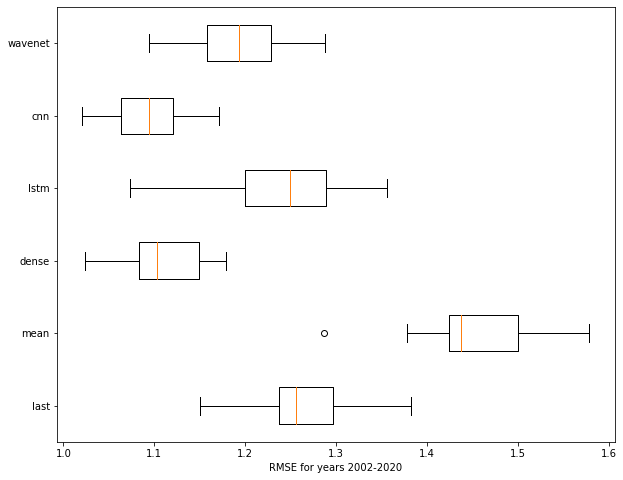

In [84]:
models = {
    "last": last,
    "mean": mean,
    "dense":dense, 
    "lstm":lstm,
    "cnn": cnn,
    "wavenet": wavenet
}

scores = {}
for key, model in models.items():
    rmses = []
    for i in range(len(years)):
        rmse = evaluate(model, Xs[i], ys[i], display=False)
        rmses.append(rmse)
    scores[key] = rmses

plt.figure(figsize=(10,8))
plt.boxplot(scores.values(), vert=False, labels=scores.keys())
plt.xlabel("RMSE for years 2002-2020")